In [26]:
import os
import pandas as pd
import kagglehub
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.functional as F
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

from data_loading.tools import reduce_mem_usage

In [3]:
# Path to the cached dataset
cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")
data_path = os.path.join(cache_path, "aryashah2k/nfuqnidsv2-network-intrusion-detection-dataset/versions/1")

if not os.path.exists(data_path):
    # Download latest version
    data_path = kagglehub.dataset_download("aryashah2k/nfuqnidsv2-network-intrusion-detection-dataset")

data_path

'/home/riley/.cache/kagglehub/datasets/aryashah2k/nfuqnidsv2-network-intrusion-detection-dataset/versions/1'

In [66]:
data = pd.read_csv(os.path.join(data_path, "NF-UQ-NIDS-v2.csv"), nrows=75_000)
data = reduce_mem_usage(data)
data.head()

Memory usage after optimization is: 11.52 MB
Decreased by 56.2%


/home/riley/base/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/riley/base/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,192.168.100.148,65389,192.168.100.7,80,6,7.0,420,3,0,0,...,0,35840,140,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
1,192.168.100.148,11154,192.168.100.5,80,6,7.0,280,2,40,1,...,0,0,0,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
2,192.168.1.31,42062,192.168.1.79,1041,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
3,192.168.1.34,46849,192.168.1.79,9110,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
4,192.168.1.30,50360,192.168.1.152,1084,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2


In [91]:
data.describe()

/home/riley/base/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/riley/base/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riley/base/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/riley/base/lib/python3.10/site-packages/pandas/core/nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)
/home/riley/base/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/riley/base/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, wher

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,75000.000000,75000.000000,75000.000000,75000.0,7.500000e+04,75000.000000,7.500000e+04,75000.000000,75000.000000,75000.000000,...,75000.00000,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,7.500000e+04,75000.0,75000.000000
mean,40465.833920,3312.146880,10.232720,NaN,8.164808e+02,8.966853,2.532995e+03,4.182373,24.228453,22.204840,...,1.59192,6023.151093,8419.387760,3727.45280,14.560360,4504.626547,1.352347,5.820372e+04,NaN,0.669427
std,18392.551582,10627.374942,5.796704,0.0,3.363638e+04,540.696801,1.322949e+05,91.180273,58.441832,58.520107,...,87.45781,13168.786190,17692.197311,11509.25313,44.958018,13358.182852,9.550069,1.568283e+07,0.0,0.470423
min,0.000000,0.000000,1.000000,0.0,4.000000e+00,1.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000
25%,27387.750000,80.000000,6.000000,0.0,5.600000e+01,1.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000
50%,45824.000000,80.000000,6.000000,7.0,1.120000e+02,2.000000,0.000000e+00,0.000000,2.000000,2.000000,...,0.00000,512.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.000000
75%,55084.000000,443.000000,17.000000,91.5,2.800000e+02,3.000000,1.520000e+02,1.000000,22.000000,6.000000,...,0.00000,4096.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.000000
max,65535.000000,65534.000000,253.000000,244.0,6.493320e+06,108222.000000,3.506066e+07,23825.000000,223.000000,223.000000,...,23131.00000,65535.000000,65535.000000,65280.00000,255.000000,65529.000000,255.000000,4.294916e+09,530.0,1.000000


In [8]:
data.columns

Index(['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES',
       'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS',
       'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN',
       'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT',
       'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack'],
      dtype='object')

In [13]:
data['FLOW_DURATION_MILLISECONDS']

0        4293092
1        4294499
2              0
3              0
4              0
          ...   
74995          0
74996    4293654
74997    4293202
74998          0
74999    4293939
Name: FLOW_DURATION_MILLISECONDS, Length: 75000, dtype: int32

In [7]:
data.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IPV4_SRC_ADDR  10000 non-null  object
 1   IPV4_DST_ADDR  10000 non-null  object
 2   Attack         10000 non-null  object
 3   Dataset        10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [104]:
scaler = MinMaxScaler()
cols_to_scale = ['FLOW_DURATION_MILLISECONDS', 'IN_BYTES', 'OUT_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_OUT_BYTES', 'DST_TO_SRC_AVG_THROUGHPUT', 'SRC_TO_DST_AVG_THROUGHPUT', 'FLOW_DURATION_MILLISECONDS']
scaled_data = data.copy()
cols_to_drop = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'Dataset']
scaled_data.drop(cols_to_drop,axis=1,inplace=True)
scaled_data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])
scaled_data["Label"] = data["Label"]
scaled_data["Attack"] = data["Attack"]
scaled_data.head()

/home/riley/base/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/riley/base/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,65389,80,6,7.0,0.000064,3,0.000000,0,2,2,...,512,0,35840,140,0,0,0,0.0,1,DoS
1,11154,80,6,7.0,0.000043,2,0.000001,1,22,2,...,512,0,0,0,0,0,0,0.0,1,DoS
2,42062,1041,6,0.0,0.000006,1,0.000001,1,22,2,...,1024,0,0,0,0,0,0,0.0,0,Benign
3,46849,9110,6,0.0,0.000006,1,0.000001,1,22,2,...,1024,0,0,0,0,0,0,0.0,0,Benign
4,50360,1084,6,0.0,0.000006,1,0.000001,1,22,2,...,1024,0,0,0,0,0,0,0.0,0,Benign


In [96]:
scaled_data.describe()

/home/riley/base/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/riley/base/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riley/base/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/riley/base/lib/python3.10/site-packages/pandas/core/nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)
/home/riley/base/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/riley/base/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, wher

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,75000.000000,75000.000000,75000.000000,75000.0,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,...,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,7.500000e+04,75000.0,75000.000000
mean,40465.833920,3312.146880,10.232720,NaN,0.000125,8.966853,0.000072,4.182373,24.228453,22.204840,...,0.385960,0.000740,0.598907,0.001737,0.001603,24.925920,0.946613,5.820372e+04,NaN,0.669427
std,18392.551582,10627.374942,5.796704,0.0,0.005180,540.696801,0.003773,91.180273,58.441832,58.520107,...,2.921012,0.018418,10.726598,0.008423,0.014452,1410.341917,9.462975,1.568283e+07,0.0,0.470423
min,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000
25%,27387.750000,80.000000,6.000000,0.0,0.000008,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000141,0.000000,1.000000,0.000000,0.000000e+00,0.0,0.000000
50%,45824.000000,80.000000,6.000000,7.0,0.000017,2.000000,0.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000326,0.000000,2.000000,0.000000,0.000000e+00,0.0,1.000000
75%,55084.000000,443.000000,17.000000,91.5,0.000043,3.000000,0.000004,1.000000,22.000000,6.000000,...,0.000000,0.000000,0.000000,0.000703,0.000207,4.000000,2.000000,0.000000e+00,0.0,1.000000
max,65535.000000,65534.000000,253.000000,244.0,1.000000,108222.000000,1.000000,23825.000000,223.000000,223.000000,...,377.000000,1.000000,622.000000,1.000000,1.000000,155185.000000,2496.000000,4.294916e+09,530.0,1.000000


In [34]:
class NetworkTrafficDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [97]:
scaled_data['Attack'].unique()

array(['DoS', 'Benign', 'scanning', 'DDoS', 'xss', 'Bot',
       'Reconnaissance', 'password', 'Fuzzers', 'injection', 'Theft',
       'Brute Force', 'Infilteration', 'Exploits', 'Generic', 'Analysis',
       'Backdoor', 'mitm', 'Shellcode', 'ransomware'], dtype=object)

In [112]:
scaled_data = scaled_data[scaled_data["Label"] != 0] # only keep attack data
X, y = scaled_data.drop(columns=["Attack", "Label"]), scaled_data["Attack"]
# Encode labels
label_encoder = {label: idx for idx, label in enumerate(y.unique())}
y_encoded = y.map(label_encoder)
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y_encoded.to_numpy(), test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
trainDataset = NetworkTrafficDataset(X_train, y_train)
valDataset = NetworkTrafficDataset(X_val, y_val)
testDataset = NetworkTrafficDataset(X_test, y_test)
train_dataloader = DataLoader(trainDataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(valDataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(testDataset,batch_size=32,shuffle=True, drop_last=True)

In [99]:
for x,y in train_dataloader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 32])
torch.Size([32])


In [116]:
class AttackClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.3):
        super(AttackClassifier, self).__init__()
        
        # Initial feature processing
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # First block with residual connection
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Residual connection adapter if dimensions don't match
        self.residual_adapter = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()
        
        # Self-attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Feature interaction block
        self.interaction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU()
        )
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        # Initial normalization
        x_normalized = self.input_bn(x)
        
        # First block with residual connection
        block1_out = self.block1(x_normalized) + self.residual_adapter(x_normalized)
        
        # Self-attention - reshaping for attention mechanism
        # Reshape to (batch_size, sequence_length=1, hidden_dim)
        attention_in = block1_out.unsqueeze(1)
        attention_out, _ = self.attention(attention_in, attention_in, attention_in)
        attention_out = attention_out.squeeze(1)  # Back to original shape
        
        # Add & norm (residual connection around attention)
        combined = self.layer_norm(block1_out + attention_out)
        
        # Feature interaction
        interaction_out = self.interaction(combined) + combined  # Another residual connection
        
        # Classification
        return self.classifier(interaction_out)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_attack_classifier.pt')
    
    return model, history

def evaluate_model(model, test_loader, criterion, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    test_loss = 0.0
    test_correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = test_correct / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    return all_preds, all_labels

In [124]:
model = AttackClassifier(input_dim=scaled_data.shape[1]-2, hidden_dim=256, num_classes=len(label_encoder))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [126]:
model, history = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=200, device=device)

Epoch [1/200] - Train Loss: 1.1858, Train Acc: 0.7294, Val Loss: 0.4834, Val Acc: 0.8575
Epoch [2/200] - Train Loss: 0.4896, Train Acc: 0.8561, Val Loss: 0.3635, Val Acc: 0.8873
Epoch [3/200] - Train Loss: 0.4035, Train Acc: 0.8785, Val Loss: 0.3230, Val Acc: 0.9072
Epoch [4/200] - Train Loss: 0.3685, Train Acc: 0.8887, Val Loss: 0.3053, Val Acc: 0.9135
Epoch [5/200] - Train Loss: 0.3467, Train Acc: 0.8943, Val Loss: 0.2843, Val Acc: 0.9162
Epoch [6/200] - Train Loss: 0.3259, Train Acc: 0.9018, Val Loss: 0.2902, Val Acc: 0.9143
Epoch [7/200] - Train Loss: 0.3133, Train Acc: 0.9035, Val Loss: 0.2668, Val Acc: 0.9197
Epoch [8/200] - Train Loss: 0.3020, Train Acc: 0.9088, Val Loss: 0.2792, Val Acc: 0.9150
Epoch [9/200] - Train Loss: 0.2953, Train Acc: 0.9093, Val Loss: 0.2548, Val Acc: 0.9274
Epoch [10/200] - Train Loss: 0.2862, Train Acc: 0.9115, Val Loss: 0.2488, Val Acc: 0.9271
Epoch [11/200] - Train Loss: 0.2759, Train Acc: 0.9163, Val Loss: 0.2471, Val Acc: 0.9230
Epoch [12/200] - Tr

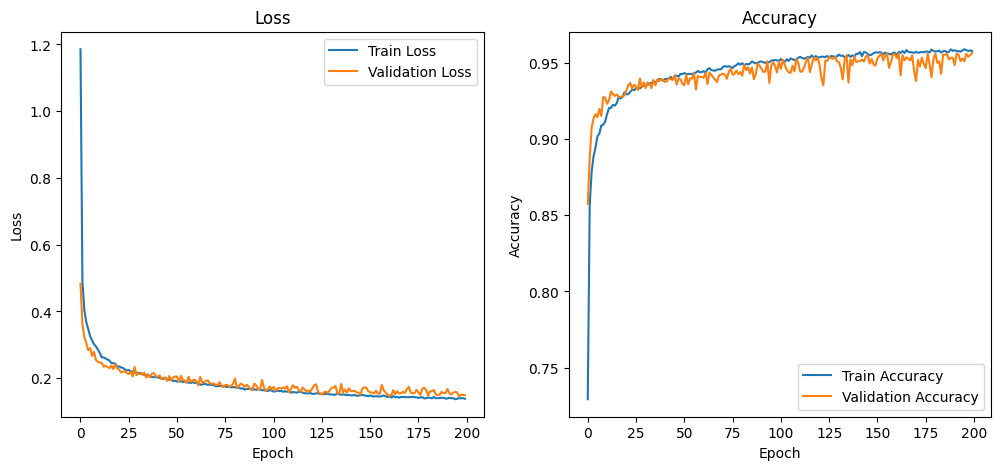

In [127]:
# plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [129]:
all_preds, all_labels = evaluate_model(model, test_dataloader, criterion, device=device)

Test Loss: 0.1648, Test Accuracy: 0.9516


In [130]:
cm = confusion_matrix(all_labels,all_preds)
recall = recall_score(all_labels,all_preds,average="weighted")
precision = precision_score(all_labels,all_preds,average="weighted")
f1 = f1_score(all_labels,all_preds,average="weighted")

print(f"recall score : {recall}")
print(f"precision score:{precision}")
print(f"f1 score :{f1}")

recall score : 0.9571314102564102
precision score:0.9551006852526805
f1 score :0.9550610441559886


/home/riley/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


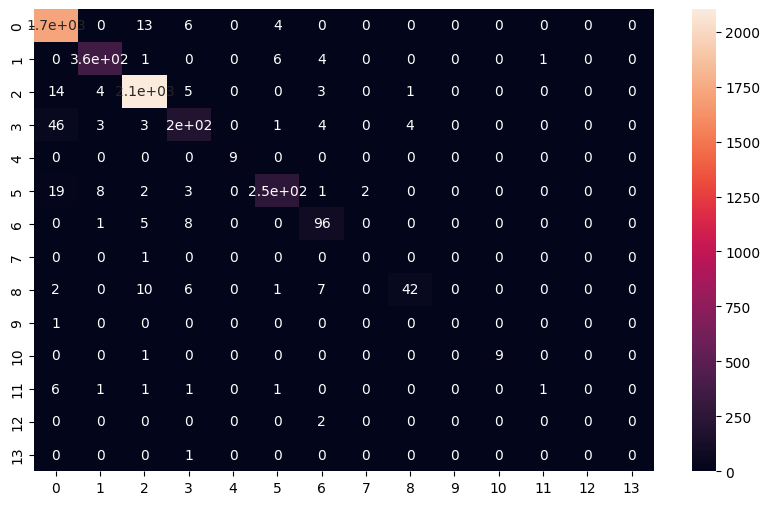

In [131]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm,annot=True,ax=ax)
plt.show()